In [64]:
from useful_scit.imps import *
import flexpart_management.modules.flx_array as fa
import flexpart_management.modules.constants as co
mpl.rcParams['figure.dpi'] = 150

In [17]:
# log.ger.setLevel(log.log.DEBUG)
log.ger.setLevel(log.log.INFO)

In [498]:
dir_path = '/homeappl/home/aliagadi/wrk/DONOTREMOVE/flexpart_management_data/runs/run_2019-08-18_18-46-19_/2018-05-11'

In [499]:
PATH = 'PATH'
DATE = 'DATE'
NAME = 'NAME'
DOM  = 'DOM'
KIND = 'KIND'
ZTOP = 'ZTOP'
MONTH = 'MONTH'

Time        = 'Time'        
ageclass    = 'ageclass'    
bottom_top  = 'bottom_top'  
releases    = 'releases'    
south_north = 'south_north' 
west_east   = 'west_east'   

D1 = 'd01'
D2 = 'd02'

In [500]:
# ds_list = fa.import_file_ds_list(dir_path,D1)

In [501]:
# concat_ds = fa.concat_file_ds_list(ds_list)

In [713]:
DD = D2
_ds_list = fa.get_flx_ds_list(DD,dir_path)
_ds_list = _ds_list[-14:]

In [714]:
ds_list = fa.trim_flx_ds_list(_ds_list)

In [715]:
dsm = xr.open_mfdataset(ds_list,concat_dim=Time,combine='nested')
dsm = fa.convert_ds_time_format(dsm)
dsm = fa.remove_ageclass(dsm)

In [716]:
hds = fa.import_head_ds(dir_path,DD)
hds = hds.drop_dims([co.SPECIES,co.RECEPTORS,co.TIME,co.AGECLASS])

In [722]:
nds = xr.merge([hds,dsm])
nds.attrs = hds.attrs.copy()
nds = fa.add_zmid(nds)

for v in (set(co.HEAD_VARS) & set(hds.variables)):
        nds = nds.assign_coords(**{v:nds[v]})

_cr = co.RELEASENAME
_df = nds[_cr].to_pandas().str.decode("utf-8")
_df = pd.to_datetime(_df,format='chc%Y%m%d_%H')
nds=nds.assign_coords(**{co.RELEASE_TIME:_df.to_xarray()})
nds = nds[{co.RL:-1}]

In [726]:
_ds = nds[co.CONC].sum([co.WEST_EAST]).load()

In [727]:
# # fig,ax = plt.subplots()
# _ds.plot(y=co.ZT,cmap=plt.get_cmap('Reds'),col=co.TIME)
# # ax.set_xlim([150,200])

In [728]:
(nds[co.XLONG].max(co.SOUTH_NORTH) - nds[co.XLONG].min(co.SOUTH_NORTH)).sum().item() == 0 

True

In [729]:
(nds[co.XLAT].max(co.WEST_EAST) - nds[co.XLAT].min(co.WEST_EAST)).sum().item()==0

True

In [730]:
VLONG = 'VLONG'
VLAT = 'VLAT'
xx = [co.XLAT,co.XLONG]
yy = [co.XLONG,co.XLAT]
ww = [co.WEST_EAST,co.SOUTH_NORTH]
vv = [VLAT,VLONG]
rr = [VLONG,VLAT]

In [731]:
_nds = nds.copy()

In [732]:
for i in range(2):
    ff = nds[xx[i]].mean(ww[i])
    ff.name = vv[i]
    _nds = _nds.assign_coords(**{vv[i]:ff})

for i in range(2):
    _nds = _nds.swap_dims({ww[i]:rr[i]})

_nds = _nds.swap_dims({co.BT:co.ZM})

In [733]:
_da = _nds[co.CONC]

In [793]:
_da1 = _da.sum([VLAT],keep_attrs=True).load()

In [794]:
# _da1.plot(col=co.TIME,col_wrap=4)

In [798]:
_da2 = _da1.loc[{VLONG:slice(-68.5,-67),co.ZM:slice(0,1e4)}]
DIS = 'Distance CHC'
_da2[DIS] = _da2[VLONG]*100
_da2[DIS] = _da2[DIS].assign_attrs(units='km')

/homeappl/home/aliagadi/appl_taito/miniconda3/envs/b36backup/lib/python3.6/site-packages/xarray/plot/plot.py:800: UserWarning: Log scale: values of z <= 0 have been masked
  primitive = ax.contourf(x, y, z, **kwargs)


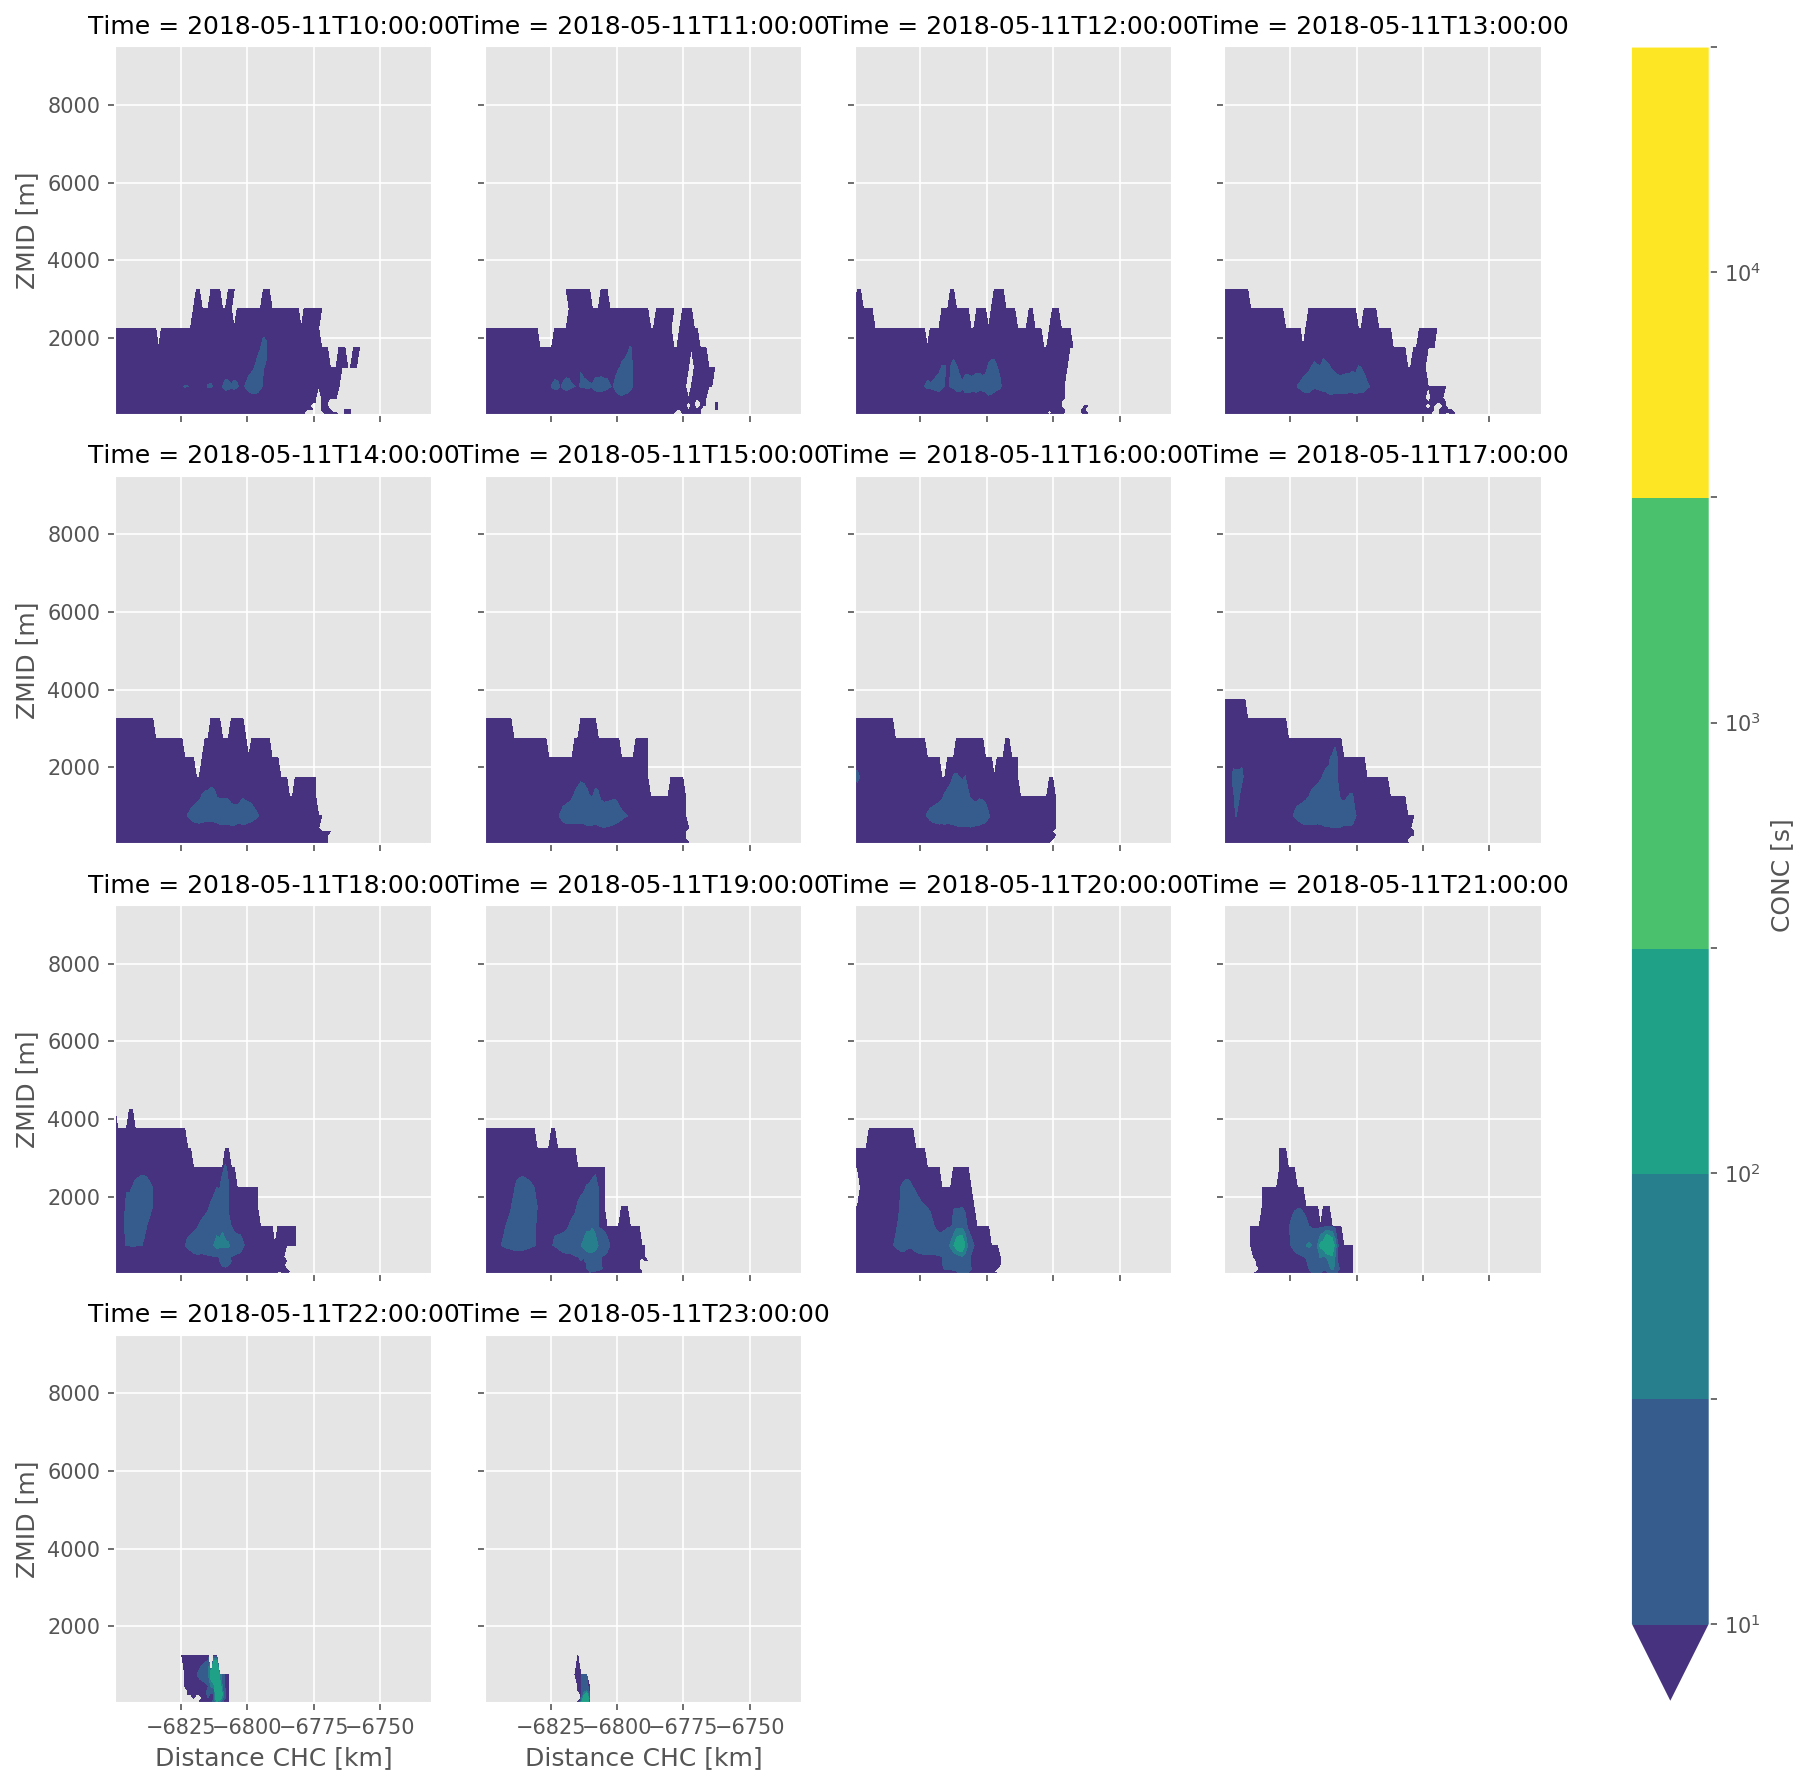

In [800]:
args = dict(   
    x=DIS,
    y=co.ZM,
    norm=mpl.colors.LogNorm(),
    vmin=10,vmax=50000
)
_da2.plot.contourf(
    **args,
    add_colorbar=True,
    levels=[10,50,100,500,1000,5000,10000,50000],
    col=co.TIME,
    col_wrap=4
)

(-5, 5)

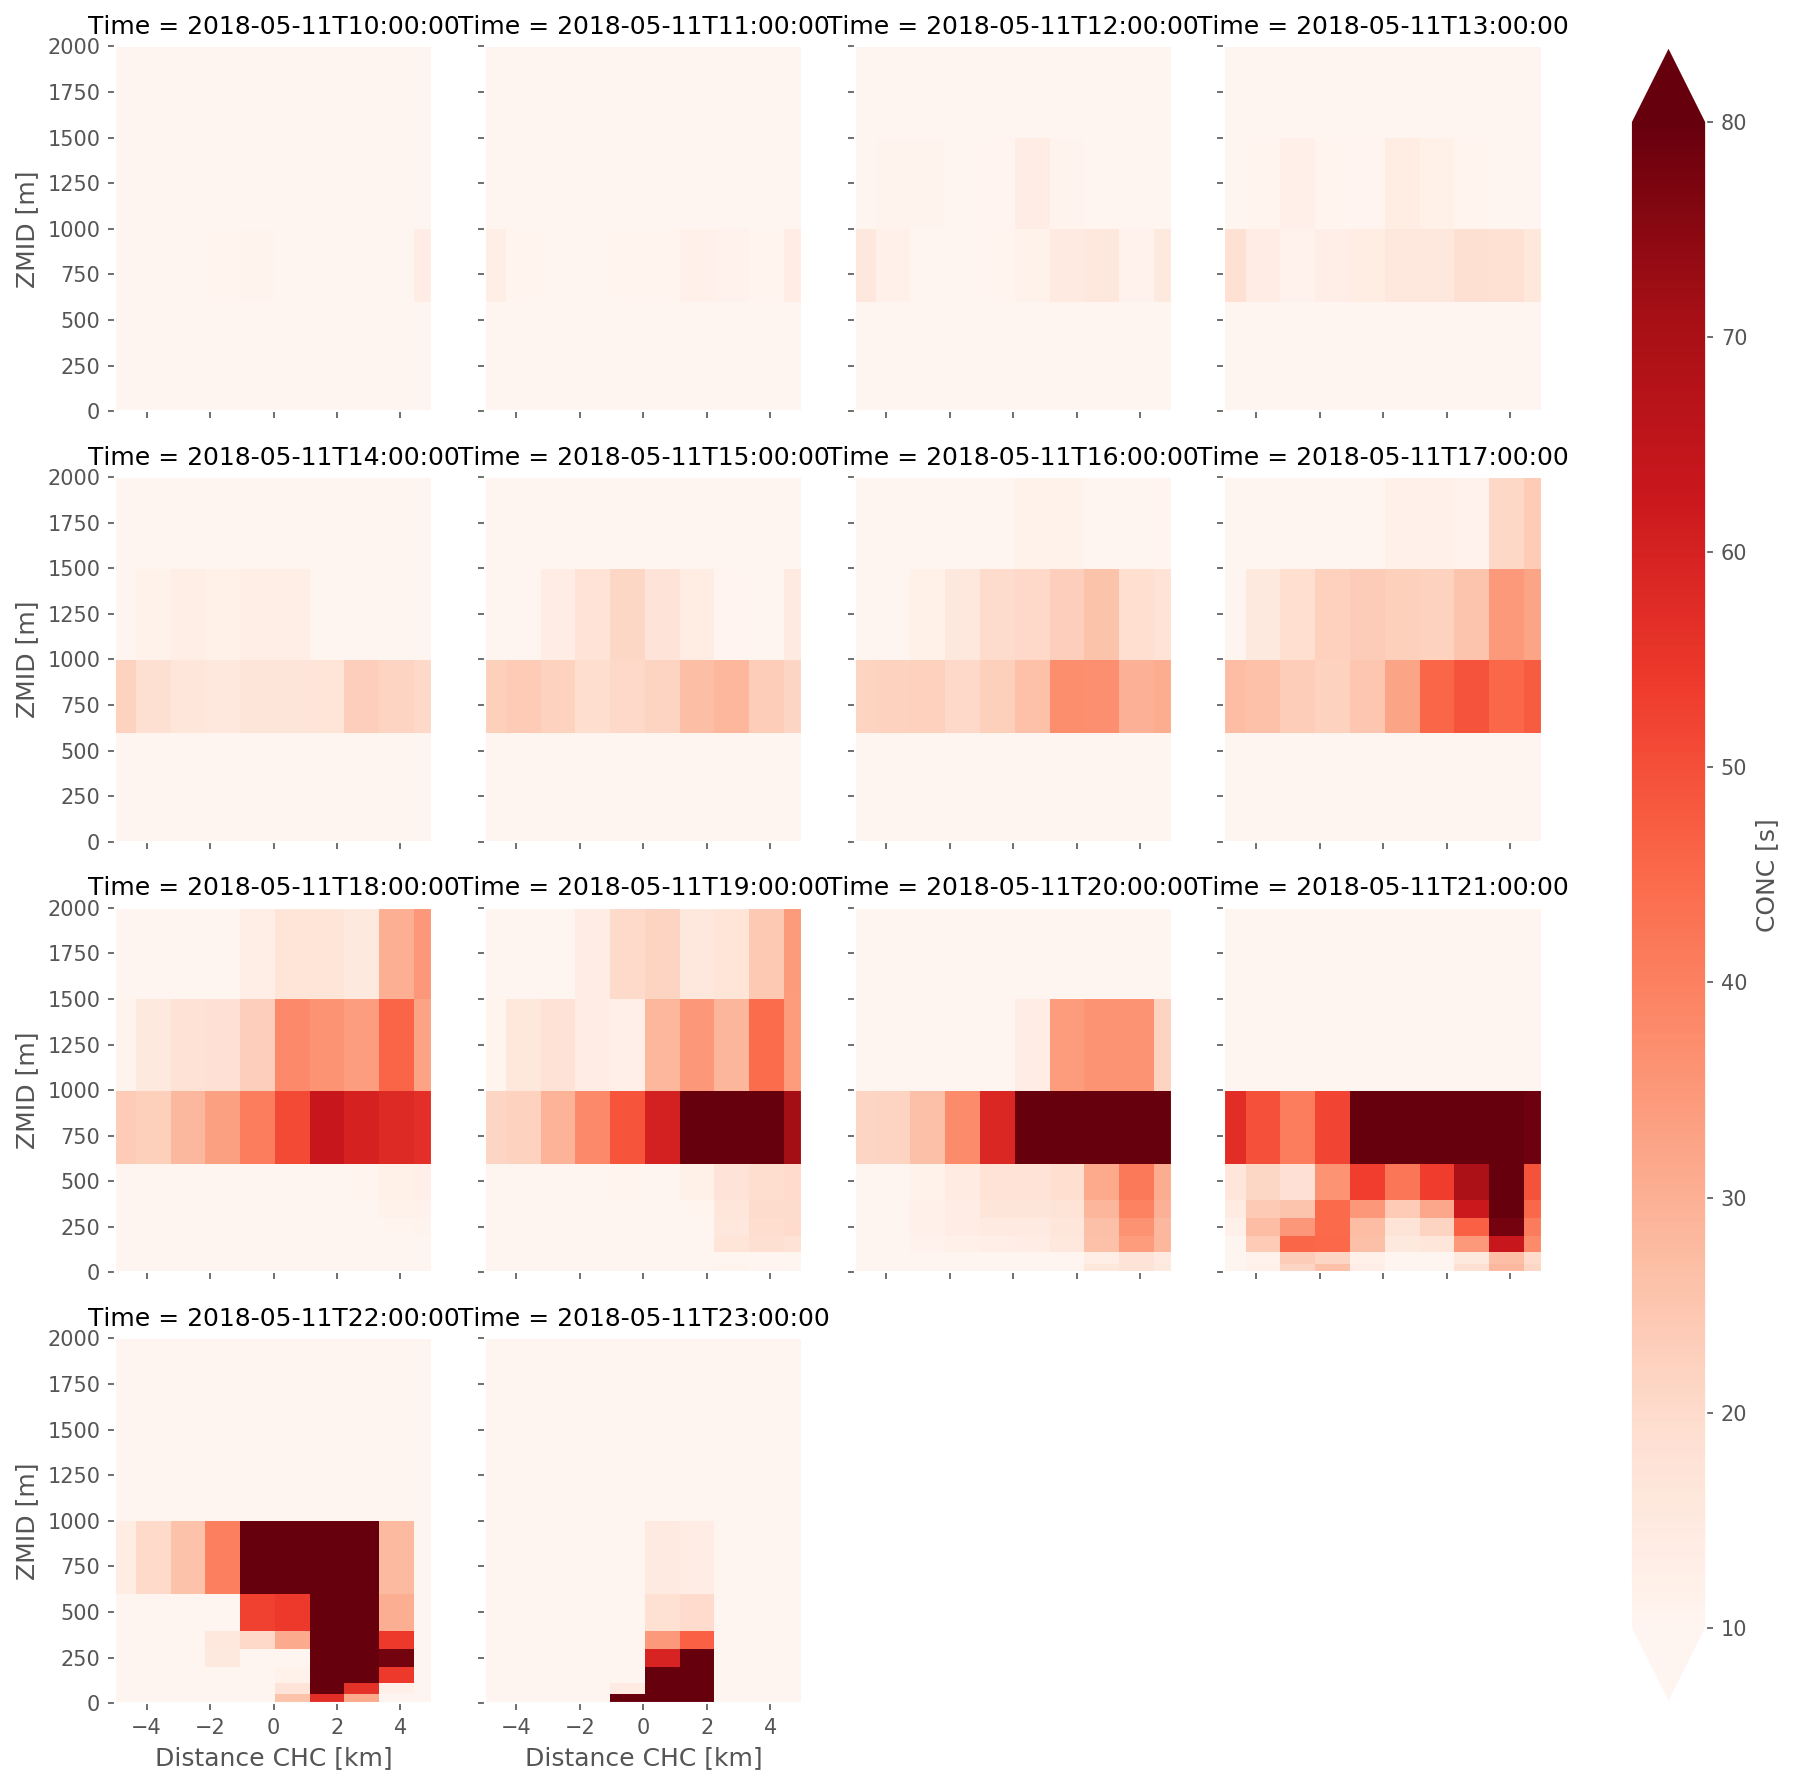

In [802]:
# fig,ax=plt.subplots(figsize=(10,5))
__da2 = _da2.copy()
__da2[DIS]=(_da2[DIS]/100-co.CHC_LON)*100
__da2[DIS]=__da2[DIS].assign_attrs(units='km')

__da2.plot(**{
    **args,
    'add_colorbar':True,
    'cmap': plt.get_cmap('Reds'),
    'norm':mpl.colors.Normalize(),
    'vmax':80,
    'col':co.TIME,
    'col_wrap':4,
    'ylim':(0,2e3),
    'xlim':(-5,5)
}

)
ax.grid(True)
ax.set_axisbelow(False)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(0,.2e4)
xl = 5
ax.set_xlim(-xl,xl);

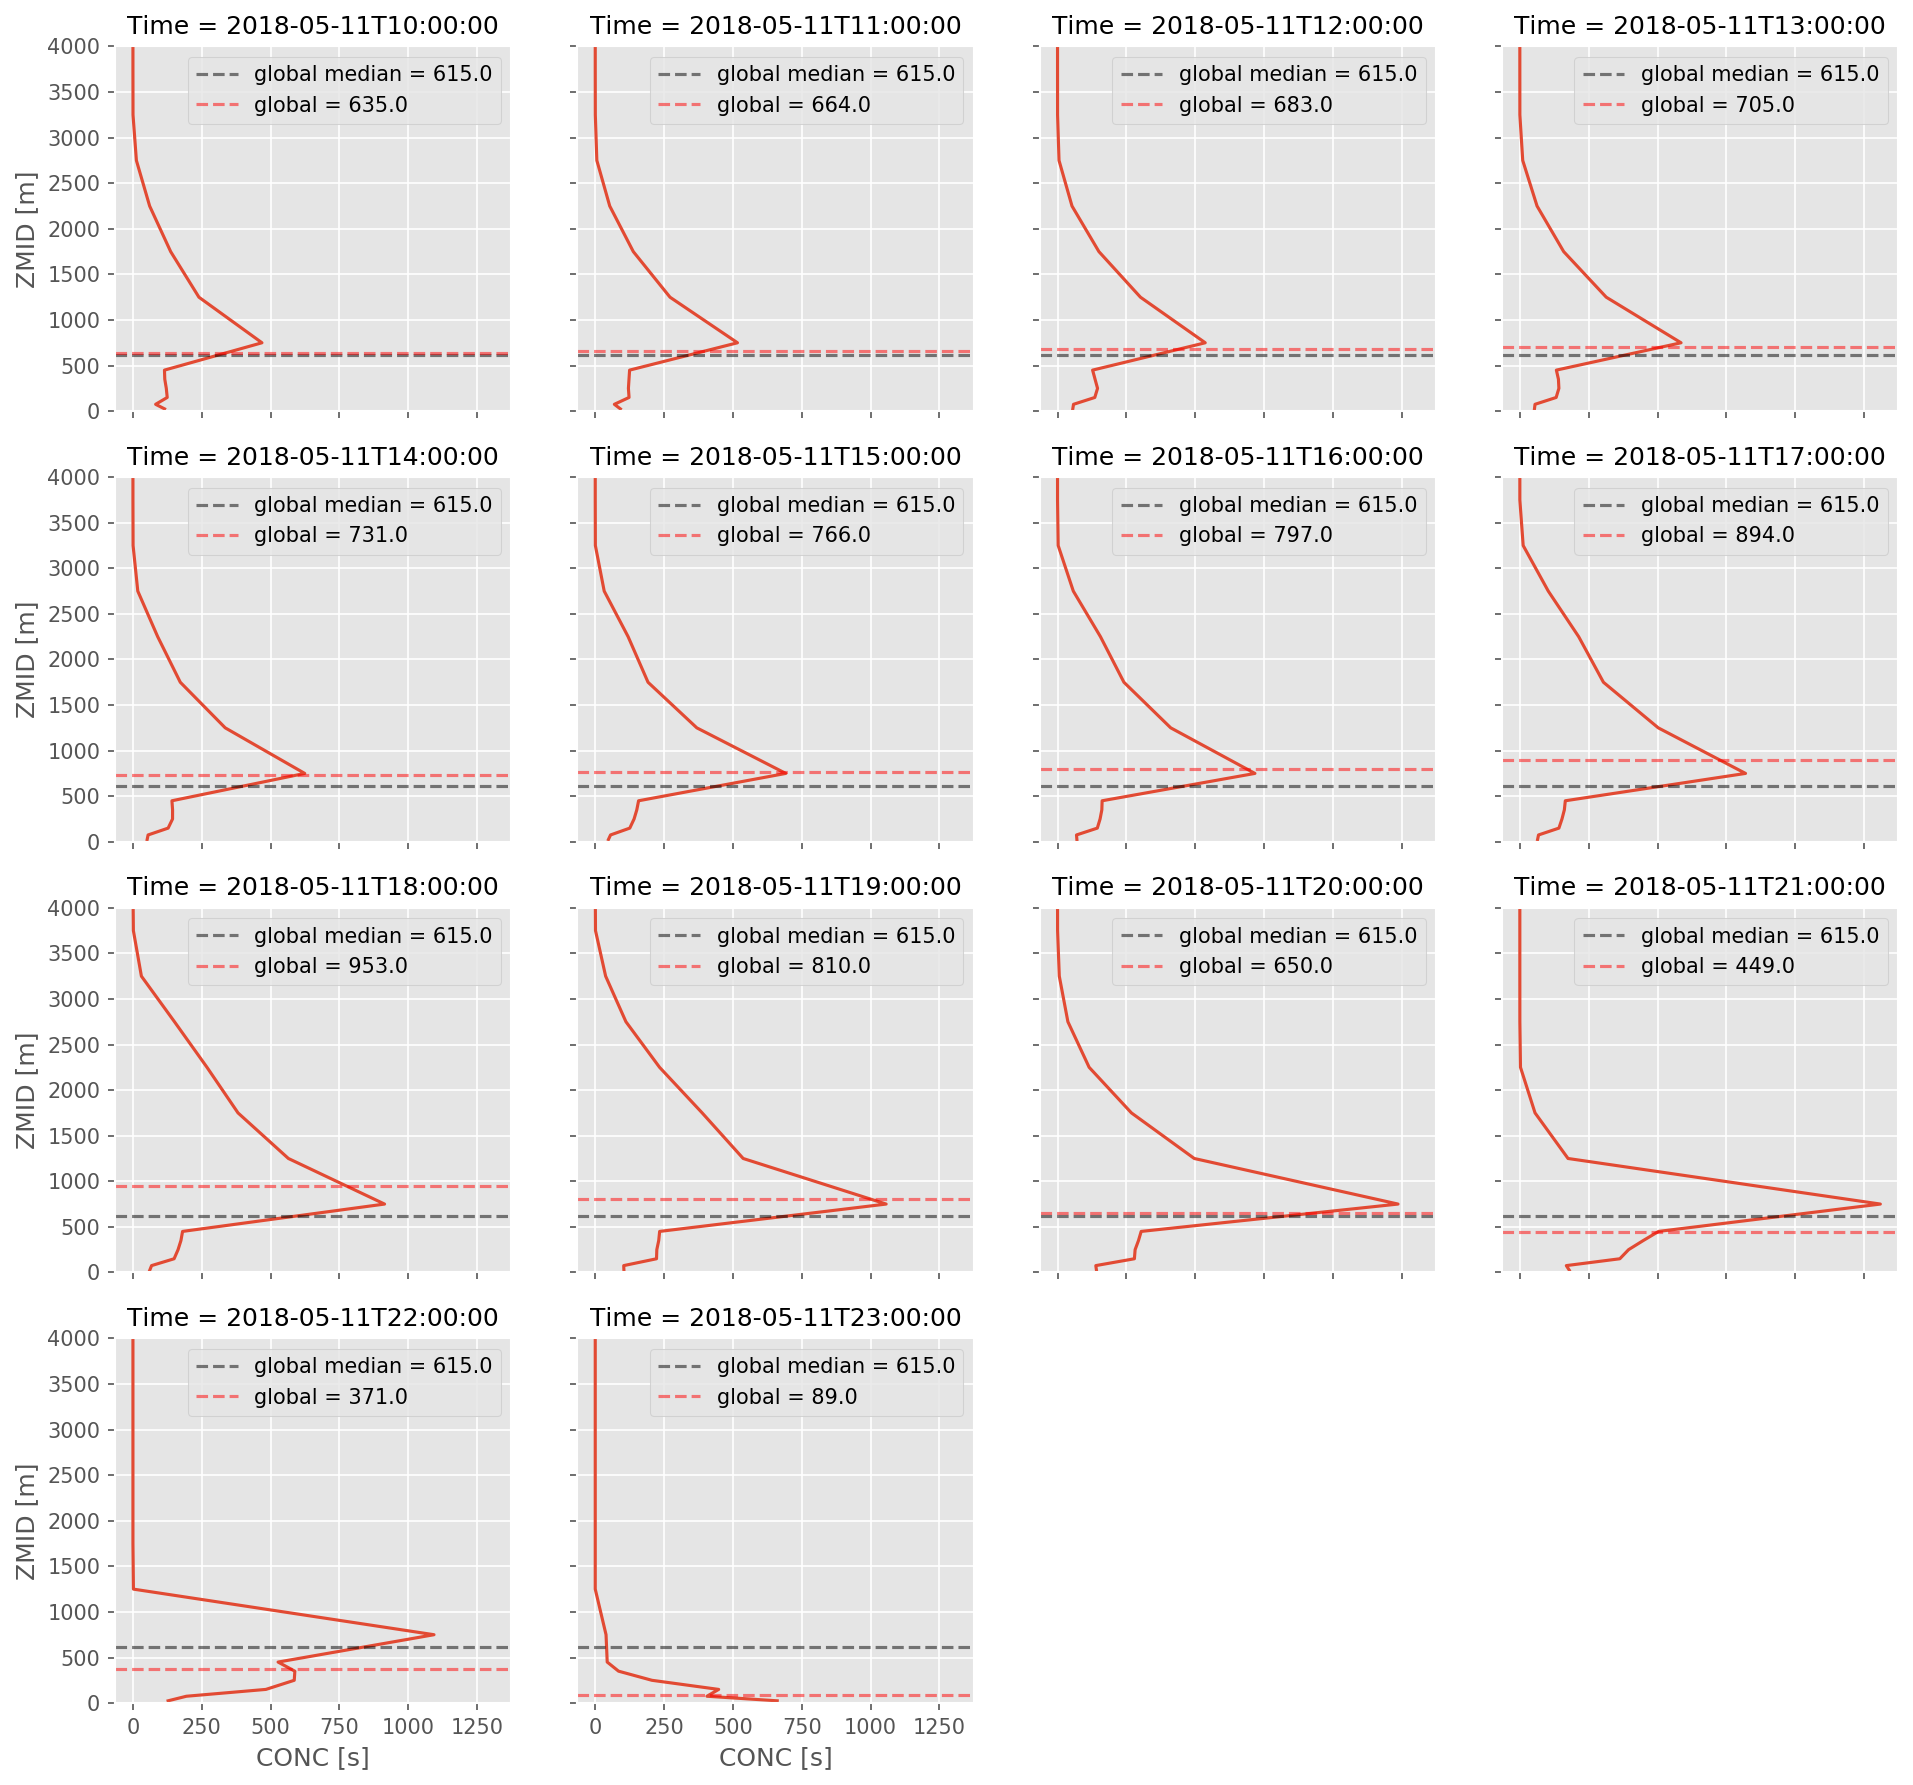

In [804]:
_dss = _da2.sum(VLONG, keep_attrs = True)
_fg = _dss.plot(col=co.TIME,y=co.ZM,col_wrap=4,ylim=(0,4e3))

_v = _da2.sum([VLONG,co.TIME],keep_attrs = True)

q50=fa.weighted_quantile(.5,_v[co.ZM],sample_weight=_v.values)

_lt = len(_dss[co.TIME])
for i,ax in enumerate(_fg.axes.flatten()[:_lt]):
    _di = _dss.isel(**{co.TIME:i})
    _q50=fa.weighted_quantile(.5,_di[co.ZM],_di.values)
    ax.axhline(q50,color='k',linestyle='--',alpha=.5,label=f'global median = {np.round(q50)}')
    ax.axhline(_q50,color='r',linestyle='--',alpha=.5,label=f'global = {np.round(_q50)}')
    ax.legend()


